# Schema matching using NLP methods 

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from gensim.models import Phrases
import gensim.downloader as api
from nltk import download
from fuzzywuzzy import fuzz
from collections import defaultdict
from difflib import SequenceMatcher
import logging

## Aux functions 

In [2]:
"""
part of https://www.analyticsinsight.net/company-names-standardization-using-a-fuzzy-nlp-approach/
"""

def text2int(textnum, numwords={}):
    if not numwords:
        units = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen",
        ]

        tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

        scales = ["hundred", "thousand", "million", "billion", "trillion"]

        numwords["and"] = (1, 0)
        for idx, word in enumerate(units):  numwords[word] = (1, idx)
        for idx, word in enumerate(tens):       numwords[word] = (1, idx * 10)
        for idx, word in enumerate(scales): numwords[word] = (10 ** (idx * 3 or 2), 0)

    ordinal_words = {'first':1, 'second':2, 'third':3, 'fifth':5, 'eighth':8, 'ninth':9, 'twelfth':12}
    ordinal_endings = [('ieth', 'y'), ('th', '')]

    # textnum = textnum.replace('-', ' ')

    current = result = 0
    curstring = ""
    onnumber = False
    for word in textnum.split():
        if word in ordinal_words:
            scale, increment = (1, ordinal_words[word])
            current = current * scale + increment
            if scale > 100:
                result += current
                current = 0
            onnumber = True
        else:
            for ending, replacement in ordinal_endings:
                if word.endswith(ending):
                    word = "%s%s" % (word[:-len(ending)], replacement)

            if word not in numwords:
                if onnumber:
                    curstring += repr(result + current) + " "
                curstring += word + " "
                result = current = 0
                onnumber = False
            else:
                scale, increment = numwords[word]

                current = current * scale + increment
                if scale > 100:
                    result += current
                    current = 0
                onnumber = True

    if onnumber:
        curstring += repr(result + current)

    return curstring


def clean_special_characters(txt):
    seps = [" ", ";", ":", ".", ",", "*", "#", "@", "|", r"/", r"\\", "-", "_", "?", "%", "!", "^", "+", "=", "(", ")", r"'", "&", "<", ">"]
    default_sep = seps[0]
    
    special_words = [
        ('street|saint', 'st'),
        ('and', '')
    ]

    for sep in seps[1:]:
        txt = txt.replace(sep, default_sep)
    
    for pattern, repl in special_words:
        txt = re.sub(r'\b' + pattern + r'\b', repl, txt)
    
    txt = txt.replace(' s ', " ")
    re.sub(' +', " ", txt)
    temp_list = [i.strip() for i in txt.split(default_sep)]
    temp_list = [i for i in temp_list if i]
    return " ".join(temp_list)


def clean_stopword(txt):
    temp_list = txt.split()
    stopwords_list = stopwords.words('english')
    temp_list = [i for i in temp_list if i not in stopwords_list]
    return " ".join(temp_list)


def data_cleaning(data, nameCol='Name', dropForeign=False):
    data = data.dropna(subset=[nameCol])
    data = data.rename_axis('idx').reset_index()
    data['nonAscii_count'] = data[nameCol].apply(lambda x: sum([not c.isascii() for c in x]))
    if dropForeign:
        data = data[data.nonAscii_count == 0]
    else:
        pass
    data = data.drop('nonAscii_count', axis=1)
    data_clean = data.copy()
    data_clean['name_clean'] = data_clean[nameCol].apply(lambda x: x.strip().lower())
    data_clean['name_clean'] = data_clean['name_clean'].apply(clean_special_characters)
    data_clean['name_clean'] = data_clean['name_clean'].apply(clean_stopword)
    # data_clean['name_clean'] = data_clean['name_clean'].apply(text2int)
    data_clean['name_clean'] = data_clean['name_clean'].apply(str.strip)

    return data_clean

## Read data 

In [3]:
def read_dfs(to_concat=False):
    """

    :param to_clean:
    :param to_concat:
    :return: if to_concat- return concated df, else- return 2 dfs, rating & loc
    """
    rating_df = pd.read_csv('tripAdvisor_data.csv')
    rating_df_clean = data_cleaning(rating_df, nameCol='name').drop_duplicates('name_clean')

    loc_df = pd.read_csv('Attractions.csv')
    loc_df = loc_df[loc_df.AddressRegion == 'Dublin']
    loc_df = loc_df[['Name', "Longitude", 'Latitude']]
    loc_df = loc_df.drop_duplicates(['Name'])
    loc_df = loc_df.rename(columns={'Name': 'name'})
    loc_df_clean = data_cleaning(loc_df, nameCol='name').drop_duplicates('name_clean')

    if to_concat:
        loc_names = loc_df.copy()
        loc_names['df'] = 'loc'
        rating_names = rating_df.copy()
        rating_names['df'] = 'rating'
        all_attractions_names = pd.concat([loc_names, rating_names], sort=False)
        df = data_cleaning(all_attractions_names, nameCol='name', dropForeign=False).drop_duplicates('name_clean')
        return df, rating_df_clean, loc_df_clean

    return rating_df_clean, loc_df_clean

In [4]:
df, rating_df, loc_df = read_dfs(to_concat=True)

In [5]:
len(rating_df), len(loc_df)

(638, 564)

In [6]:
def remove_joined_names(rating_df, loc_df):
    joined = pd.merge(rating_df, loc_df, on='name_clean', suffixes=['_rating', '_loc'])

    rating_df = rating_df.set_index('name_clean', drop=False).drop(index=joined['name_clean']).set_index('idx', drop=False)
    loc_df = loc_df.set_index('name_clean', drop=False).drop(index=joined['name_clean']).set_index('idx', drop=False)

    return rating_df, loc_df, joined

# similarity

In [6]:
class Similarity:
    def similarity(self, texts1, texts2) -> np.ndarray:
        sim = np.zeros((len(texts1), len(texts2)))
                       
        for i, x in enumerate(texts1):
            for j, y in enumerate(texts2):
                sim[i][j] = self.single_similarity(x, y)
        
        return sim
    
    def single_similarity(self, text1, text2) -> float:
        pass

# exact match

In [8]:
class ExactSimilarity(Similarity):
    def single_similarity(self, text1, text2) -> float:
        if text1 == text2:
            return 1.0
        
        return 0.0

In [11]:
exact_similarity = ExactSimilarity()
exact_sim = exact_similarity.similarity(loc_df.name_clean, rating_df.name_clean)
exact_sim = exact_sim * 100

1.0

## tfidf

In [64]:
def ngrams(string, n=3):
    string = re.sub(r'[,-./]|\sBD', r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]


class TFIDFSimilarity(Similarity):
    def __init__(self, names1, names2):
        self.vectorizer = TfidfVectorizer(analyzer=ngrams)
        joined = pd.concat([names1, names2])
        self.vectorizer.fit_transform(joined)
    
    def similarity(self, names1, names2):
        X1 = self.vectorizer.transform(names1)
        X2 = self.vectorizer.transform(names2)
        similarity = X1.dot(X2.T)
        return similarity.toarray()

In [128]:
tfidf_similarity = TFIDFSimilarity(loc_df.name_clean, rating_df.name_clean)
tfidf_sim = tfidf_similarity.similarity(loc_df.name_clean, rating_df.name_clean)
tfidf_sim = tfidf_sim * 100 

Code for creating Heat Map

In [129]:
tfidf_max_i_for_j = match_i_j_greedy(tfidf_sim)

In [190]:
loc_names = []
rating_names = []
scores = []
loc_idxs = []
rating_idxs = []

for j, i in tfidf_max_i_for_j.items():
#     if all_sims_max[i,j] > 0.7:
    loc_names.append(loc_df.iloc[i].name_clean)
    rating_names.append(rating_df.iloc[j].name_clean)
    scores.append(tfidf_sim[i,j])
    loc_idxs.append(i)
    rating_idxs.append(j)

tfidf_res_df = pd.DataFrame(list(zip(rating_names, loc_names, scores, loc_idxs, rating_idxs)),
                            columns =['rating_name', 'loc_name', 'score', "loc_idxs", "rating_idxs"])
tfidf_res_df = tfidf_res_df[tfidf_res_df.score > 87]
print(len(tfidf_res_df))
tfidf_res_df = tfidf_res_df[tfidf_res_df.rating_name!=tfidf_res_df.loc_name]#.head(20)
print(len(tfidf_res_df))
tfidf_res_df 

98
4


,rating_name,loc_name,score,loc_idxs,rating_idxs
39,kilmainham gaol museum,kilmainham gaol,88.039731,43,4
58,post general post office,general post office,91.571589,68,114
144,james clarence mangan bust,james clarence mangan,89.306374,182,471
206,sporting emporium casino dublin,sporting emporium casino,91.845682,307,134


In [191]:
loc_idxs = tfidf_res_df.loc_idxs.to_list()
rating_idxs = tfidf_res_df.rating_idxs.to_list() 

heat_map_scores = np.zeros(shape=(len(loc_idxs), len(rating_idxs)))
print(heat_map_scores.shape)
for idx1, i in enumerate(loc_idxs):
    for idx2, j in enumerate(rating_idxs):
        heat_map_scores[idx1][idx2] = tfidf_sim[i][j]
heat_map_scores   

(4, 4)


array([[88.03973144,  0.        ,  0.        ,  0.        ],
       [ 0.        , 91.57158883,  0.        ,  0.        ],
       [ 0.        ,  0.        , 89.30637368,  0.        ],
       [ 0.        ,  0.        ,  0.        , 91.84568164]])

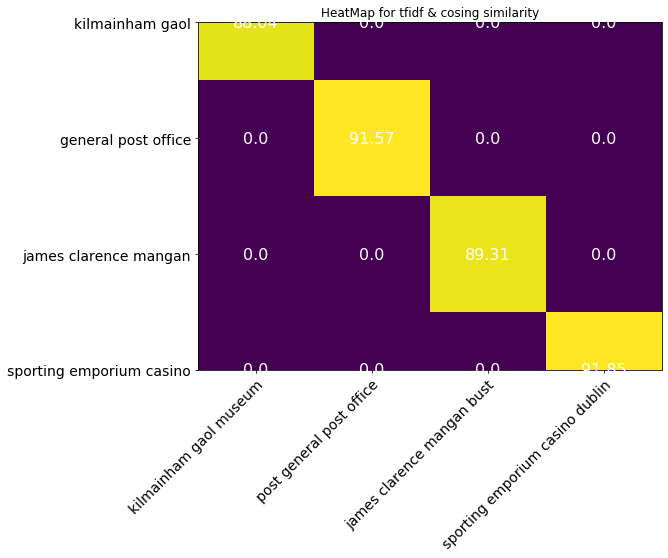

<Figure size 432x288 with 0 Axes>

In [192]:
loc = loc_df.name_clean.iloc[loc_idxs].to_list()
rating = rating_df.name_clean.iloc[rating_idxs].to_list() 

tfidf_array = heat_map_scores.round(2) #[:10, :10]


fig, ax = plt.subplots()
im = ax.imshow(tfidf_array, )

# We want to show all ticks...
ax.set_xticks(np.arange(len(rating)))
ax.set_yticks(np.arange(len(loc)))
# ... and label them with the respective list entries
ax.set_xticklabels(rating, fontsize=14)
ax.set_yticklabels(loc, fontsize=14)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(loc)):
    for j in range(len(rating)):
        text = ax.text(j, i, tfidf_array[i, j],
                       ha="center", va="center", color="w", fontsize=16)

ax.set_title("HeatMap for tfidf & cosing similarity")
fig.tight_layout()
fig.set_size_inches(20, 20)
plt.show() 
plt.savefig(fname='heatmap.png')

In [213]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontsize=16)
    ax.set_yticklabels(row_labels, fontsize=16)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw, fontsize=18)
            texts.append(text)

    return texts

SyntaxError: invalid syntax (<ipython-input-213-cafe3d831250>, line 26)

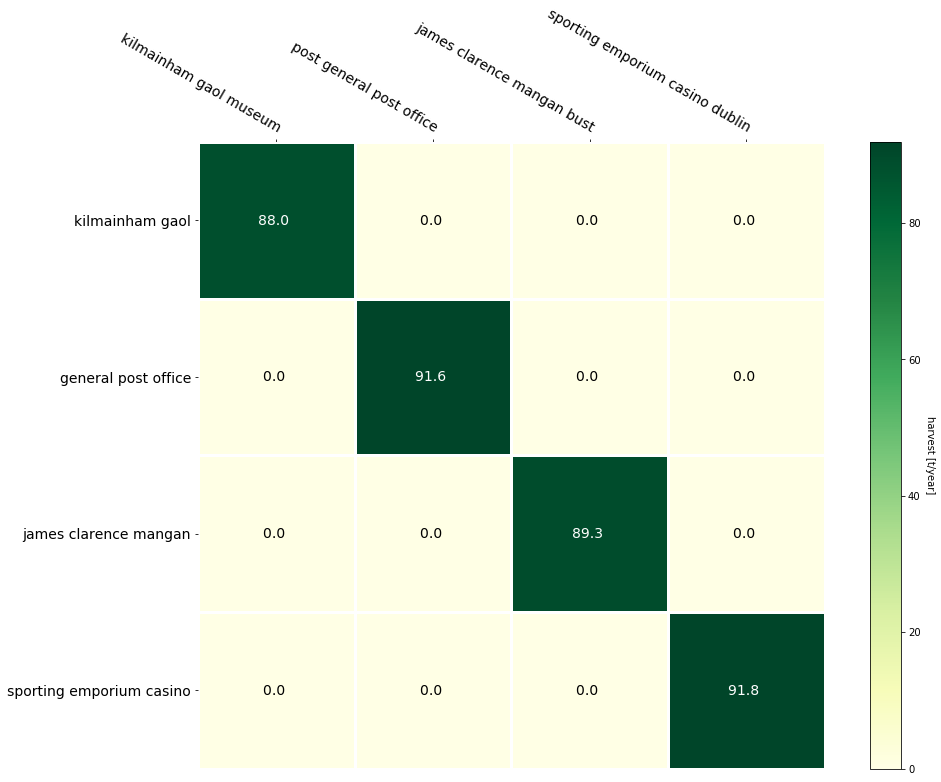

In [214]:
fig, ax = plt.subplots()

im, cbar = heatmap(tfidf_array, loc, rating, ax=ax,
                   cmap="YlGn", cbarlabel="harvest [t/year]")
texts = annotate_heatmap(im, valfmt="{x:.1f} ")

fig.tight_layout()
fig.set_size_inches(20, 20)
plt.show()

# difflib sequenceMatcher similarity

In [15]:
class difflib_sequenceMatcher(Similarity):
    def single_similarity(self, text1, text2) -> float:
        return SequenceMatcher(None, text1, text2).ratio() 

In [16]:
difflib_similarity = difflib_sequenceMatcher()
difflib_sim = difflib_similarity.similarity(loc_df.name_clean, rating_df.name_clean)
difflib_sim = difflib_sim * 100 

1.0

# fuzz similarity 

In [17]:
class fuzzSimilarity(Similarity):
    def single_similarity(self, text1, text2) -> float:
        s1 = fuzz.token_set_ratio(text1, text2) + 0.000000000001
        s2 = fuzz.partial_ratio(text1, text2) + 0.000000000001
        return 2*s1*s2 / (s1+s2)

In [18]:
fuzz_similarity = fuzzSimilarity()
fuzz_sim = fuzz_similarity.similarity(loc_df.name_clean, rating_df.name_clean)
fuzz_sim.max()

100.000000000001

# wmd

In [7]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


class WMDSimilarity(Similarity):
    def __init__(self, path):
        self.model = api.load(path)
        download('stopwords')  # Download stopwords list.
        self.stop_words = stopwords.words('english')
        
    def single_similarity(self, text1, text2) -> float:
        text1 = [w for w in text1.split() if w not in self.stop_words]
        text2 = [w for w in text2.split() if w not in self.stop_words]
        return self.model.wmdistance(text1, text2)

In [ ]:
WMD_similarity = WMDSimilarity('word2vec-google-news-300')
WMD_sim = WMD_similarity.similarity(loc_df.name_clean, rating_df.name_clean)
# WMD_sim = WMD_sim * 100 

In [52]:
print(WMD_sim)

[[3.62720937 3.63210605 3.40152698 ... 4.29350613 3.64186834 3.56554277]
 [3.88706532 3.81934316 3.87214337 ... 4.60459798 3.85758903 3.95710408]
 [4.07020182 4.08179004 4.160716   ... 1.9446218  4.0802799  3.86596785]
 ...
 [2.78502895 3.91806414 3.85363462 ... 4.42044687 3.68473934 3.65420797]
 [2.38662472 3.61088371 4.00876352 ... 4.66743193 3.91289412 4.1179045 ]
 [3.03743592 3.21784404 4.26908209 ... 4.65148439 4.19434736 4.28736437]]


In [53]:
WMD_sim[WMD_sim == np.inf] = -1
WMD_sim.max()

5.958060264587402

In [34]:
WMD_sim.sort(axis=0)
WMD_sim

array([[ 0.,  0.,  0., ..., inf, inf, inf],
       [ 0.,  0.,  0., ..., inf, inf, inf],
       [ 0.,  0.,  0., ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

Code for creating similarity graph 

In [25]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,100), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
    
# display_closestwords_tsnescatterplot(WMD_similarity.model, word=loc_df.name_clean[10])

In [ ]:
sentences = []
for df in [loc_df.name_clean, rating_df.name_clean]:
    for name in df:
        sent = []
        for word in name.split():
            sent.append(word)
        sentences.append(sent)


bigram_transformer = Phrases(sentences)
# # Apply the trained MWE detector to a corpus, using the result to train a Word2vec model.
model = Word2Vec(bigram_transformer[sentences], min_count=1, size=100)


display_closestwords_tsnescatterplot(model, 'sculpture') #loc_df.name_clean[10].split()[1])
display_closestwords_tsnescatterplot(model, 'st')
display_closestwords_tsnescatterplot(model, 'catedral')

# aggregate similarities

In [50]:
all_sims = np.stack([exact_sim, tfidf_sim, difflib_sim, fuzz_sim]) #, WMD_sim])

In [51]:
all_sims_max = all_sims.max(axis=0)

In [52]:
all_sims.shape

(4, 564, 638)

In [53]:
all_sims_max.max() #sanety check 

100.000000000001

In [54]:
all_sims_max.shape

(564, 638)

# matching

In [88]:
def match_i_j_greedy(similarity):
    max_j_for_i = similarity.argmax(axis=1)
    max_i_for_j = defaultdict()

    for i, j in enumerate(max_j_for_i):
        if j not in max_i_for_j:
            max_i_for_j[j] = i
        else:
            current_sim = similarity[max_i_for_j[j], j]
            if current_sim < similarity[i, j]:
                max_i_for_j[j] = i
                
    return max_i_for_j

In [56]:
max_i_for_j = match_i_j_greedy(all_sims_max)

In [73]:
loc_names = []
rating_names = []
scores = []

for j, i in max_i_for_j.items():
#     if all_sims_max[i,j] > 0.7:
    loc_names.append(loc_df.iloc[i].name_clean)
    rating_names.append(rating_df.iloc[j].name_clean)
    scores.append(all_sims_max[i,j])

agg_res_df = pd.DataFrame(list(zip(rating_names, loc_names, scores)), columns =['agg_rating_name', 'agg_loc_name', 'agg_score'])
# agg_res_df = agg_res_df[agg_res_df.agg_score > 70]
print(len(agg_res_df))

286


## take exact mathces 

In [74]:
agg_res_df_100 = agg_res_df[agg_res_df.agg_score >99]
print(len(agg_res_df_100))
agg_res_df_100.sort_values('agg_score') 

124


,agg_rating_name,agg_loc_name,agg_score
0,racing tours ireland,racing tours ireland,100.0
166,patrick kavanagh statue,patrick kavanagh,100.0
165,monument oscar wilde,oscar wilde,100.0
164,molly malone statue,molly malone,100.0
162,james joyce statue,james joyce,100.0
...,...,...,...
54,spire,spire,100.0
52,temple bar,temple bar cultural trust temple bar cultural ...,100.0
49,st patrick cathedral,st patrick cathedral,100.0
65,st mary pro cathedral,st mary pro cathedral,100.0


## hand-choose from 70%-99% mathces 

In [81]:
agg_res_df_70_99 = agg_res_df[(agg_res_df.agg_score <99) & (agg_res_df.agg_score >70)]
print('before removing mistakes:', len(agg_res_df_70_99))
agg_res_df_70_99.sort_values('agg_score') 

agg_idxs_to_remove = [117, 197, 16, 181, 256, 169, 146, 73, 176, 113, 140, 191, 9, 186, 265, 97, 199, 14, 151, 245, 102, 182, 273, 218, 243, 105, 136, 184, 233]
not_sure = [142, 152, 226, 127, 50, 96, 53, 249]
agg_res_df_70_99 = agg_res_df_70_99.drop(index=agg_idxs_to_remove)
print('after removing mistakes:', len(agg_res_df_70_99))
agg_res_df_70_99

before removing mistakes: 55
after removing mistakes: 26


,agg_rating_name,agg_loc_name,agg_score
33,james joyce bust,james joyce museum,84.894118
50,steine,stena line,75.000000
53,ambassador event centre,ambassador theatre,78.048780
74,blessington st park basin,blessington st basin dublin secret garden,84.260355
90,blanchardstown centre,leisureplex blanchardstown,80.000000
96,griffith bridge,griffith park,76.496732
107,seapoint beach,seapoint blue flag beach 2019,88.268156
112,dun laoghaire rathdown library,dun laoghaire rathdown heritage society,83.988095
115,king inns,kings inns,94.736842
120,rathmichael church,rathmichael lodge,74.786667


# combine final result table 

In [85]:
matches_df = pd.concat([
                        agg_res_df_100,
                        agg_res_df_70_99
                        ])
matches_df = matches_df.rename(columns={'agg_loc_name': 'loc_name', 'agg_rating_name':'rating_name'})
len(matches_df)
matches_df

,rating_name,loc_name,agg_score
0,racing tours ireland,racing tours ireland,100.000000
2,macau casino club dublin,macau casino club,100.000000
3,gallery photography,gallery photography,100.000000
4,vaults live,vaults live,100.000000
6,sandycove beach,sandycove beach,100.000000
...,...,...,...
241,séamus ennis arts centre,seamus ennis arts centre,96.989691
249,powerscourt house,powerscourt theatre,80.472050
262,gormleys fine art,gormley fine art,96.969697
268,revolution 1916,1916 ride revolution rise rebels bus tour hidd...,84.393064


In [92]:
loc_merged = pd.merge(loc_df.rename(columns={'name_clean':'loc_name'}), matches_df, on='loc_name')
loc_merged.drop(columns=['idx', 'name'], inplace=True)
loc_merged

,Longitude,Latitude,loc_name,rating_name,agg_score
0,-6.265696,53.341171,macau casino club,macau casino club dublin,100.000000
1,-6.137493,53.374989,bull island,bull island,100.000000
2,-6.267419,53.342900,dublin castle,dublin castle,100.000000
3,-6.267149,53.343922,dublin city hall,city hall,100.000000
4,-6.372209,53.288411,civic theatre,civic theatre,100.000000
...,...,...,...,...,...
145,-6.277493,53.343579,vaults live,vaults live,100.000000
146,-6.284198,53.343248,guinness storehouse,guinness storehouse,100.000000
147,-6.270211,53.352507,14 henrietta st,14 henrietta st,100.000000
148,-6.276364,53.337285,dublin liberties distillery,dublin liberties distillery,100.000000


In [96]:
final_df = pd.merge(loc_merged, rating_df.rename(columns={'name_clean':'rating_name'}), on='rating_name', suffixes=['_loc', '_rating'])
final_df.drop(columns=['idx', 'name'], inplace=True)
final_df 

,Longitude,Latitude,loc_name,rating_name,agg_score,rating,category
0,-6.265696,53.341171,macau casino club,macau casino club dublin,100.000000,506,CASINOS & GAMBLING
1,-6.137493,53.374989,bull island,bull island,100.000000,74,NATURE & PARKS
2,-6.267419,53.342900,dublin castle,dublin castle,100.000000,43,SIGHTS & LANDMARKS
3,-6.267149,53.343922,dublin city hall,city hall,100.000000,82,MUSEUMS
4,-6.372209,53.288411,civic theatre,civic theatre,100.000000,161,CONCERTS & SHOWS
...,...,...,...,...,...,...,...
145,-6.277493,53.343579,vaults live,vaults live,100.000000,30,CONCERTS & SHOWS
146,-6.284198,53.343248,guinness storehouse,guinness storehouse,100.000000,9,MUSEUMS
147,-6.270211,53.352507,14 henrietta st,14 henrietta st,100.000000,17,MUSEUMS
148,-6.276364,53.337285,dublin liberties distillery,dublin liberties distillery,100.000000,52,FOOD & DRINK


In [97]:
final_df.to_csv('rating_loc_attractions.csv', index=True)  